In [1]:
from utils import *
from modules import *
import numpy as np 
import pandas as pd
from PIL import Image
import os
from os import listdir
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import rand_score,adjusted_rand_score
from sklearn.decomposition import PCA
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore")

## Functions

In [9]:
def evaluation(datas,labels,verbose=False):
    titles = ["X_train","Representation Latente","X_train_hat"]
    scores = []
    puritities = []
    rand_scores= []
    for i,data in enumerate(datas):

        shape = data.shape[1]
        nb_classes = len(np.unique(labels))
        n_samples = X_train.shape[0]

        neuro_i_1 = shape
        neuro_o_1 = shape // 2
        neuro_i_2 = shape // 2
        neuro_o_2 = shape // 4
        neuro_i_3 = shape // 4
        neuro_o_3 = nb_classes
        facteur_norma = 0.4
        plage_biais = (0,1)
        batch_size = 100
        epochs = 50


        facteur_norma = 0.8
        lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
        lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
        lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)
        TanH = ModuleTanH()
        sigmoide = ModuleSigmoide()
        mseloss = MSELoss()
        CE = CrossEntropieLoss(nb_classes)
        softmax = SoftMax()


        network_layers = [lineaire_1,TanH,lineaire_2,TanH,lineaire_3,softmax]
        network = Sequentiel(network_layers)

        if verbose : print("Optimisation de : ",titles[i])
        opti = Optim(network,CE,1e-3)
        opti.SGD(data,labels,batch_size,epochs)

        score = opti.getNetwork().accuracy(data,labels) 
        scores.append(score)
        if verbose : print("Accuracy sur les images issues de l'auto encodeur",score)    

        kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000).fit(data)
        yhat = kmeans.labels_
        
        purete = cluster_purity(yhat,labels)
        puritities.append(purete)
        
        rs  = rand_score(yhat,labels)
        rand_scores.append(rs)
        
        if verbose : 
            print("Pureté du clustering : ",purete)
            print("Rand score  : ",rs)
            print("Adjusted Rand Score : ",adjusted_rand_score(yhat,labels))
            print()

        
        
    return scores,puritities,rand_scores
        
        
        
def optimisation_espace_latent(data,labels,verbose=False):
    
    nb_classes = len(np.unique(labels))
    n_samples = data.shape[0]
    scores = []
    purtities = []
    rand_scores= []
    
    dim_espace_latent_list = [10,20,30,40,50]
    
    for dim_espace_latent in dim_espace_latent_list:
        

        neuro_i_1 = 256
        neuro_o_1 = 160
        neuro_i_2 = 160
        neuro_o_2 = 120
        neuro_i_3 = 120
        neuro_o_3 = 60
        neuro_i_4 = 60
        neuro_o_4 = dim_espace_latent
        
        facteur_norma = 0.4
        plage_biais = (0,1)
        batch_size = 100
        epochs = 100
        nb_couches = 4


        facteur_norma = 0.8


        lineaire_1_enc = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
        lineaire_2_enc = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
        lineaire_3_enc = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)
        lineaire_4_enc = ModuleLineaire(neuro_i_4 ,neuro_o_4 ,plage_biais,facteur_norma,init=1)

        lineaire_1_dec = ModuleLineaire(neuro_o_1 ,neuro_i_1 ,plage_biais,facteur_norma,init=1)
        lineaire_2_dec = ModuleLineaire(neuro_o_2 ,neuro_i_2 ,plage_biais,facteur_norma,init=1)
        lineaire_3_dec = ModuleLineaire(neuro_o_3 ,neuro_i_3 ,plage_biais,facteur_norma,init=1)
        lineaire_4_dec = ModuleLineaire(neuro_o_4 ,neuro_i_4 ,plage_biais,facteur_norma,init=1)

        TanH = ModuleTanH()
        sigmoide = ModuleSigmoide()
        BCE = BinaryCrossEntropie()


        network_layers = [lineaire_1_enc,TanH,lineaire_2_enc,TanH,lineaire_3_enc,TanH,lineaire_4_enc,TanH,
                          lineaire_4_dec,TanH,lineaire_3_dec,TanH,lineaire_2_dec,TanH,lineaire_1_dec,sigmoide]
        network = Sequentiel(network_layers)

        auto_encodeur_usps = AutoEncodeur(network,BCE)

        
        if verbose : print("Dimension espace latent : ",dim_espace_latent)
        
        auto_encodeur_usps.optimisation(data,labels,batch_size,epochs,1e-4,False)
        latent_repre = auto_encodeur_usps.encode(data)
        
        datas = [latent_repre]
        score,purete,rand_score = evaluation(datas,labels,verbose)
        scores.append(score)
        purities.append(purete)
        rand_scores.append(rand_score)
        
    return scores , purities , rand_scores

In [ ]:
scores,purities,rand_scores = optimisation_espace_latent(X_train,Y_train)

  7%|███                                        | 7/100 [00:10<02:31,  1.63s/it]

In [8]:
scores

[[0.46444052014769627],
 [0.84170813934821],
 [0.8291860651790014],
 [0.8791138224434099],
 [0.8710868518221223]]

In [ ]:
plt.plot(np.arange(len(scores)),scores)
plt.title("Accuracy en fonction de la dimension ")
plt.show()

## Lineaire

In [2]:
# definir un jeu de données lineairement separable 
seed = 42
np.random.seed(seed)
pos_cen = (-12, -12)
pos_sig = [[1, 4], [4, 1]]

neg_cen = (-2, -2)
neg_sig = [[1, 5], [4, 1]]
data,labels = genere_dataset_gaussian(pos_cen,pos_sig,neg_cen,neg_sig,100,-1,1)
labels = labels.reshape(-1,1)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2772.98it/s]


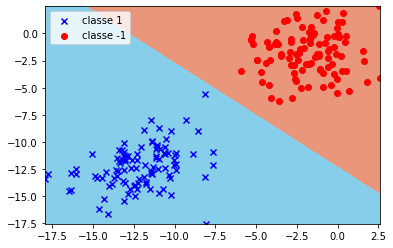

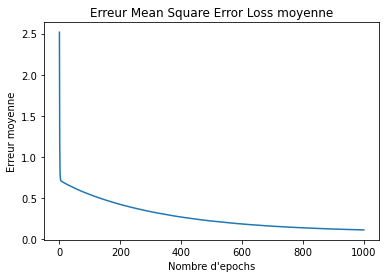

Accuracy  :  1.0


In [3]:
# definir un reseau linaire
facteur_norma = 0.4
plage_biais = (0,1)
neuro_i = 2
neuro_o = 1
batch_size = 50
epochs = 1000

lineaire = ModuleLineaire(neuro_i,neuro_o,plage_biais,facteur_norma,init=1)
mseloss = MSELoss()
network_layers = [lineaire]
network = Sequentiel(network_layers)

opti = Optim(network,mseloss,1e-5)
opti.SGD(data,labels,batch_size,epochs)
opti.affichage(data,labels)

## Non lineaire

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 384.44it/s]


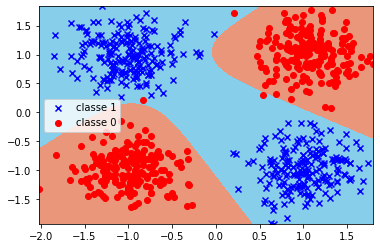

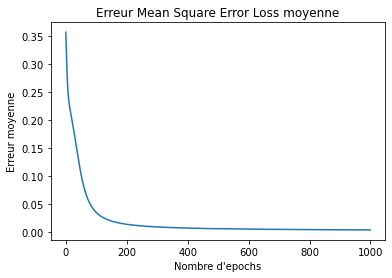

Accuracy  :  0.99625


In [4]:
# definir un jeu de données XOR

seed = 42
np.random.seed(seed)
data_xor , labels_xor = create_XOR(200,0.1)


neuro_i_1 = 2
neuro_o_1 = 4
neuro_i_2 = 4
neuro_o_2 = 1
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 1000


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()


network_layers = [lineaire_1,TanH,lineaire_2,sigmoide]
network = Sequentiel(network_layers)


opti = Optim(network,mseloss,1e-3)
opti.SGD(data_xor,labels_xor,batch_size,epochs)
opti.affichage(data_xor,labels_xor)

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 252.03it/s]


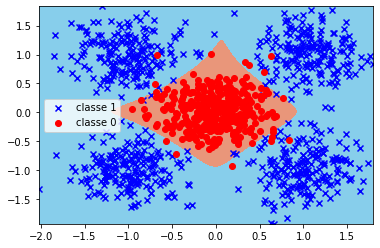

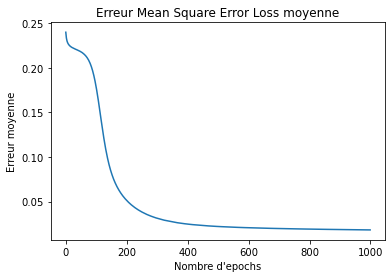

Accuracy  :  0.9825


In [5]:
# definir un jeu de données XOR

seed = 42
np.random.seed(seed)
data_dirac , label_dirac = create_data_dirac(200,0.1)


neuro_i_1 = 2
neuro_o_1 = 4
neuro_i_2 = 4
neuro_o_2 = 1
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 1000


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()


network_layers = [lineaire_1,TanH,lineaire_2,sigmoide]
network = Sequentiel(network_layers)


opti = Optim(network,mseloss,1e-3)
opti.SGD(data_dirac,label_dirac,batch_size,epochs)
opti.affichage(data_dirac,label_dirac)

## Multi Classe

In [4]:
import pickle as pkl
data = pkl.load(open("data/usps.pkl",'rb'))

X_train = data["X_train"]
Y_train = data["Y_train"]
X_test = data["X_test"]
Y_test = data["Y_test"]

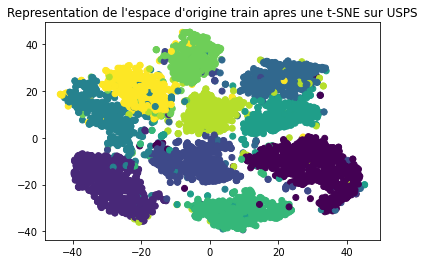

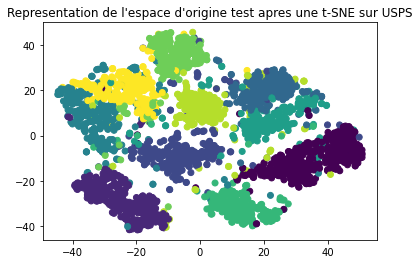

In [4]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)
repre_2D = tsne.fit_transform(X_train)

plt.title("Representation de l'espace d'origine train apres une t-SNE sur USPS")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)
plt.show()

repre_2D = tsne.fit_transform(X_test)

plt.title("Representation de l'espace d'origine test apres une t-SNE sur USPS")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)
plt.show()

100%|███████████████████████████████████████████| 50/50 [00:28<00:00,  1.75it/s]


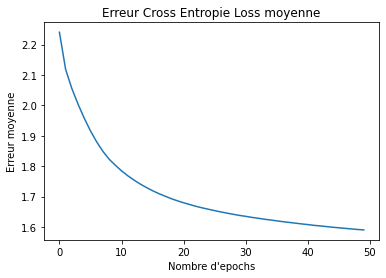

Accuracy  :  0.934339380317868


In [5]:
np.random.seed(42)
nb_classes = len(np.unique(Y_train))
n_samples = X_train.shape[0]

neuro_i_1 = 256
neuro_o_1 = 120
neuro_i_2 = 120
neuro_o_2 = 60
neuro_i_3 = 60
neuro_o_3 = 10
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 50


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()
CE = CrossEntropieLoss(nb_classes)
softmax = SoftMax()


network_layers = [lineaire_1,TanH,lineaire_2,TanH,lineaire_3,softmax]
network = Sequentiel(network_layers)

opti = Optim(network,CE,1e-3)
opti.SGD(X_train,Y_train,batch_size,epochs)
opti.affichage(X_train,Y_train)

In [7]:
print("Accuracy sur le train : ",opti.getNetwork().accuracy(X_train,Y_train))
print("Accuracy sur le test : ",opti.getNetwork().accuracy(X_test,Y_test))

Accuracy sur le train :  0.934339380317868
Accuracy sur le test :  0.8419680677745194


## Auto-encodeur

### Encodage d'images

Optimisation
Batch size :  100
Epochs :  100
Learning rate :  0.0001


100%|█████████████████████████████████████████| 100/100 [03:03<00:00,  1.83s/it]


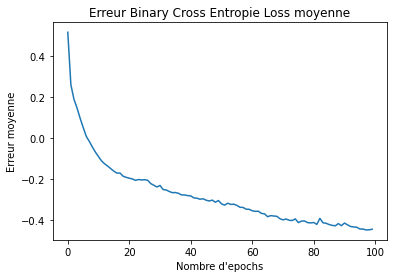

In [8]:
np.random.seed(42)
nb_classes = len(np.unique(Y_train))
n_samples = X_train.shape[0]

neuro_i_1 = 256
neuro_o_1 = 160
neuro_i_2 = 160
neuro_o_2 = 120
neuro_i_3 = 120
neuro_o_3 = 60
neuro_i_4 = 60
neuro_o_4 = 10
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 100
epochs = 100
nb_couches = 4


facteur_norma = 0.8


lineaire_1_enc = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
lineaire_2_enc = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
lineaire_3_enc = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)
lineaire_4_enc = ModuleLineaire(neuro_i_4 ,neuro_o_4 ,plage_biais,facteur_norma,init=1)

lineaire_1_dec = ModuleLineaire(neuro_o_1 ,neuro_i_1 ,plage_biais,facteur_norma,init=1)
lineaire_2_dec = ModuleLineaire(neuro_o_2 ,neuro_i_2 ,plage_biais,facteur_norma,init=1)
lineaire_3_dec = ModuleLineaire(neuro_o_3 ,neuro_i_3 ,plage_biais,facteur_norma,init=1)
lineaire_4_dec = ModuleLineaire(neuro_o_4 ,neuro_i_4 ,plage_biais,facteur_norma,init=1)

TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
BCE = BinaryCrossEntropie()


network_layers = [lineaire_1_enc,TanH,lineaire_2_enc,TanH,lineaire_3_enc,TanH,lineaire_4_enc,TanH,
                  lineaire_4_dec,TanH,lineaire_3_dec,TanH,lineaire_2_dec,TanH,lineaire_1_dec,sigmoide]
network = Sequentiel(network_layers)

auto_encodeur_usps = AutoEncodeur(network,BCE)

auto_encodeur_usps.optimisation(X_train,Y_train,batch_size,epochs,1e-4)

### Train

In [9]:
latent_repre = auto_encodeur_usps.encode(X_train)
X_train_hat = auto_encodeur_usps.decode(latent_repre)

#### t-SNE

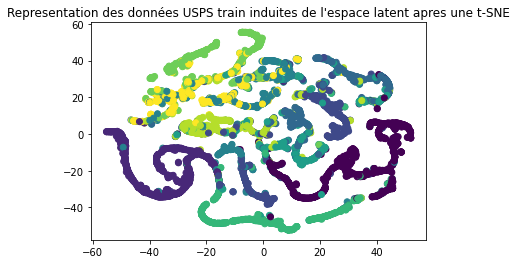

In [10]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)
repre_2D = tsne.fit_transform(X_train_hat)

plt.title("Representation des données USPS train induites de l'espace latent apres une t-SNE")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)

- On remarque la representation t-SNE des images induites de l'espace latent est plus condensées que l'espace d'origine . Plusieurs images reconstruites se superpose.

#### PCA

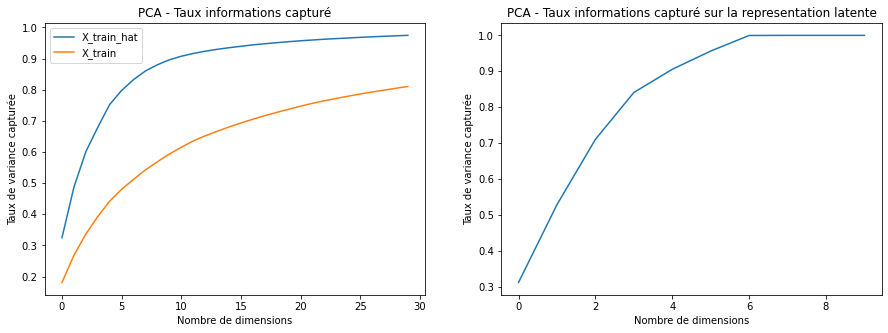

La quantité d'information moyenne perdue pendant le decodage :  0.027494231145577273


In [31]:
pca_1 = PCA(n_components=30,random_state=96)
pca_1.fit(X_train_hat)

pca_2 = PCA(n_components=30,random_state=96)
pca_2.fit(X_train)

pca_3 = PCA(n_components=10,random_state=96)
pca_3.fit(latent_repre)


plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_))
plt.legend(["X_train_hat","X_train"])
plt.title("PCA - Taux informations capturé")
plt.xlabel("Nombre de dimensions")
plt.ylabel("Taux de variance capturée")


plt.subplot(122)
plt.plot(np.cumsum(pca_3.explained_variance_ratio_))
plt.title("PCA - Taux informations capturé sur la representation latente")
plt.xlabel("Nombre de dimensions")
plt.ylabel("Taux de variance capturée")

plt.show()

quantite_info_apres_decodage = pca_1.explained_variance_ratio_[:10]
quantite_info_espace_latent = pca_3.explained_variance_ratio_
print("La quantité d'information moyenne perdue pendant le decodage : ",
      np.abs( quantite_info_apres_decodage - quantite_info_espace_latent ).mean())

- Le taux d'informations capturé sur la representation latente converge vers un taux de 100% au bout de 6 dimensions . 
- On remarque aussi que le taux d'informations augmente plutot rapidement au fil des dimensions , ce qui veut dire que l'encodage de l'information est plutot pas mal.
- Conclusion : la dimension ideale d'arrivée de l'encodeur peut etre fixé à 6 .


- Le taux d'informations recuperé sur les données issues de l'espace latent augmente plus rapidement par rapport à celles des données de l'espace d'origine.  
- Le taux d'informations recuperé sur les données issues de l'espace latent arrivé à 100% au bout de 30 dimensions contrairement à celles des données de l'espace d'origine qui arrve uniquement à 80% de l'informations.
- Ce qui peut expliquer la condensation de la representations des données issues de l'espace latent sur une t-SNE car les exemples issues de la meme classe ont presque la meme representation (meme coordonnées) donc peut de composantes suffisent pour les representer ( la variance va etre maximal sur un nombre de composantes petit ) contrairement aux données de l'espace d'origine qui sont moins condensées c'est pour cela que un grand nombre de composantes est necessaire pour capturer le maximum d'information.
- la difference de la quantité d'informations recuperés dans l'espace latent et celle du decodage de cet espace doit etre minimale pour pouvoir dire que le decodage a pu garder l'information de l'espace latent ( l'information de l'espace d'origine reduites en dimension )  
- Un bon espace latent (regroupant le max d'informations de l'espace d'origine) permet de decoder de nouvelles images avec un pattern de chiffre parfait ( prend en compte le pattern de tous les chiffres de la classe y compris les images bruités).
- les données USPS d'origine présentent une quantité de bruit et de la redondance, ce qui peut brouiller la structure sous-jacente des données. Dans ce cas, la compression de dimension (l'encodage) aide à éliminer une partie du bruit et de la redondance, ce qui peut conduire à une PCA de meilleure qualité pour la représentation de dimension réduite.

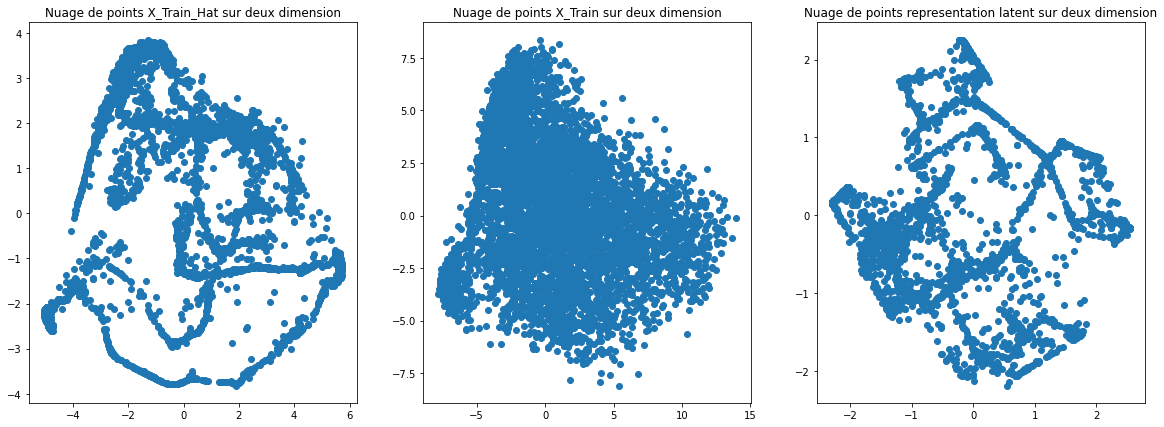

In [32]:
X_train_hat_pca = pca_1.transform(X_train_hat)
X_train_pca = pca_2.transform(X_train)
latent_repre_pca = pca_3.transform(latent_repre)

plt.figure(figsize=(20,7))

plt.subplot(131)
plt.scatter(X_train_hat_pca[:,0],X_train_hat_pca[:,1])
plt.title("Nuage de points X_Train_Hat sur deux dimension")

plt.subplot(132)
plt.scatter(X_train_pca[:,0],X_train_pca[:,1])
plt.title("Nuage de points X_Train sur deux dimension")

plt.subplot(133)
plt.scatter(latent_repre_pca[:,0],latent_repre_pca[:,1])
plt.title("Nuage de points representation latent sur deux dimension")


plt.show()

#### Visualisation des Images

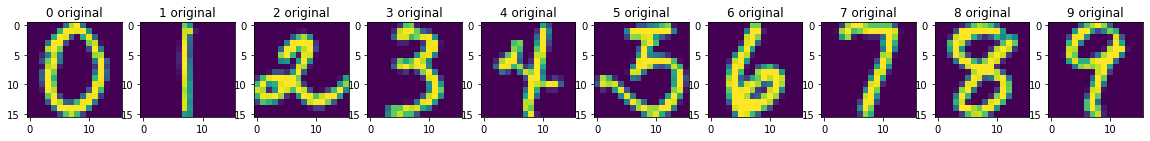

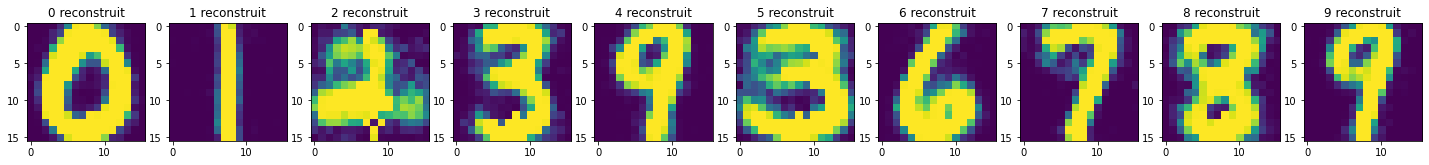

In [33]:
plt.figure(figsize=(20,15))
sample = np.random.randint(0,100)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_train[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_train_hat[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

#### Evaluation 

In [15]:
datas = [X_train,latent_repre,X_train_hat]
evaluation(datas,Y_train)

Optimisation de :  X_train


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.76it/s]


Accuracy sur les images issues de l'auto encodeur 0.9290415797078183
Pureté du clustering :  0.7068550329105795
Rand score  :  0.9131695728218426
Adjusted Rand Score :  0.5448117147373678

Optimisation de :  Representation Latente


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 41.68it/s]


Accuracy sur les images issues de l'auto encodeur 0.5323486916037887
Pureté du clustering :  0.6837373575212715
Rand score  :  0.9082111011817948
Adjusted Rand Score :  0.5199676370093268

Optimisation de :  X_train_hat


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.93it/s]


Accuracy sur les images issues de l'auto encodeur 0.839781666399101
Pureté du clustering :  0.7153636217691444
Rand score  :  0.9131331756397063
Adjusted Rand Score :  0.5514264502554621



### Test

In [16]:
latent_repre = auto_encodeur_usps.encode(X_test)
X_test_hat = auto_encodeur_usps.decode(latent_repre)

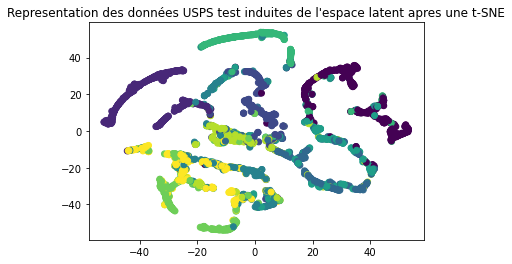

In [17]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)
repre_2D = tsne.fit_transform(X_test_hat)

plt.title("Representation des données USPS test induites de l'espace latent apres une t-SNE")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)

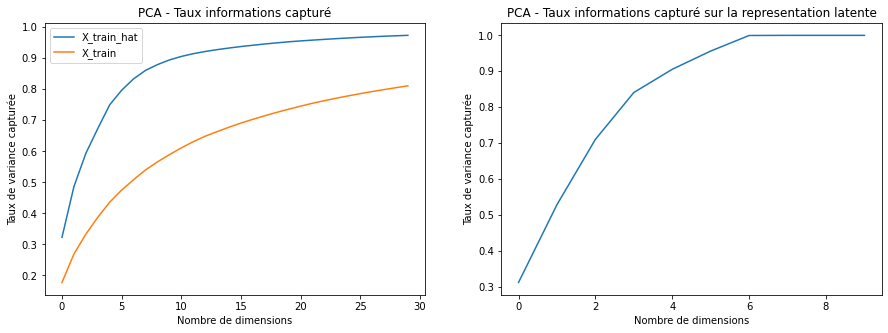

La quantité d'information moyenne perdue pendant le decodage :  0.02733375203575284


In [34]:
pca_1 = PCA(n_components=30,random_state=96)
pca_1.fit(X_test_hat)

pca_2 = PCA(n_components=30,random_state=96)
pca_2.fit(X_test)

pca_3 = PCA(n_components=10,random_state=96)
pca_3.fit(latent_repre)


plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_))
plt.legend(["X_train_hat","X_train"])
plt.title("PCA - Taux informations capturé")
plt.xlabel("Nombre de dimensions")
plt.ylabel("Taux de variance capturée")


plt.subplot(122)
plt.plot(np.cumsum(pca_3.explained_variance_ratio_))
plt.title("PCA - Taux informations capturé sur la representation latente")
plt.xlabel("Nombre de dimensions")
plt.ylabel("Taux de variance capturée")

plt.show()

quantite_info_apres_decodage = pca_1.explained_variance_ratio_[:10]
quantite_info_espace_latent = pca_3.explained_variance_ratio_
print("La quantité d'information moyenne perdue pendant le decodage : ",
      np.abs( quantite_info_apres_decodage - quantite_info_espace_latent ).mean())

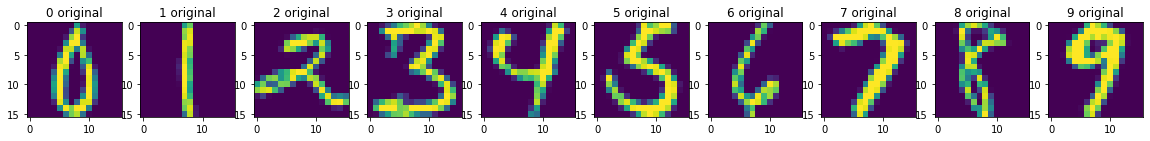

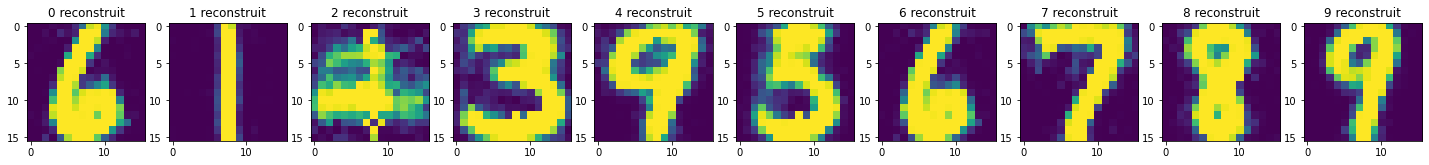

In [35]:
plt.figure(figsize=(20,15))
sample = np.random.randint(0,100)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_test[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_test_hat[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

- Constatation : 
    - La representation sur t-SNE des données USPS induites de l'espace latent est plus condensée.
- Raison : 
    - Hypothése : l'architecture de l'auto encodeur telle definie elimine les bruits sur les images , ainsi deux images de l'espace original auront pratiquement la meme reprensentation dans le nouveau espace latent vu que le bruit definie l'affinité entre les images . En eliminant trop de bruits ( nombre d'epochs grand ou architecture plus profonde ) le decodage de l'espace latent serra presque le meme quelque soit la classe de l'image .
    - Compromis à trouver : un compromis doit etre trouvé pour essayer d'eliminer la quantité de bruits qui permet de dissocier les classes des images de base. Ainsi : 
    - - reduire peu : ne permet pas un decodage de l'espace latent.
    - - reduire trop : ne permet pas de discriminer les images selon leurs classes.

### Vérification de l'hypothése

#### Augmentation de la profondeur du reseau

Optimisation
Batch size :  100
Epochs :  100
Learning rate :  0.0001


100%|█████████████████████████████████████████| 100/100 [03:46<00:00,  2.26s/it]


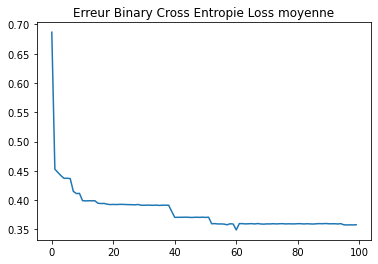

In [29]:
np.random.seed(42)
nb_classes = len(np.unique(Y_train))
n_samples = X_train.shape[0]

neuro_i_1 = 256
neuro_o_1 = 200
neuro_i_2 = 200
neuro_o_2 = 160
neuro_i_3 = 160
neuro_o_3 = 120
neuro_i_4 = 120
neuro_o_4 = 70
neuro_i_5 = 70
neuro_o_5 = 40
neuro_i_6 = 40
neuro_o_6 = 10


facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 100
epochs = 100
nb_couches = 4


facteur_norma = 0.8


lineaire_1_enc = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
lineaire_2_enc = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
lineaire_3_enc = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)
lineaire_4_enc = ModuleLineaire(neuro_i_4 ,neuro_o_4 ,plage_biais,facteur_norma,init=1)
lineaire_5_enc = ModuleLineaire(neuro_i_5 ,neuro_o_5 ,plage_biais,facteur_norma,init=1)
lineaire_6_enc = ModuleLineaire(neuro_i_6 ,neuro_o_6 ,plage_biais,facteur_norma,init=1)

lineaire_1_dec = ModuleLineaire(neuro_o_1 ,neuro_i_1 ,plage_biais,facteur_norma,init=1)
lineaire_2_dec = ModuleLineaire(neuro_o_2 ,neuro_i_2 ,plage_biais,facteur_norma,init=1)
lineaire_3_dec = ModuleLineaire(neuro_o_3 ,neuro_i_3 ,plage_biais,facteur_norma,init=1)
lineaire_4_dec = ModuleLineaire(neuro_o_4 ,neuro_i_4 ,plage_biais,facteur_norma,init=1)
lineaire_5_dec = ModuleLineaire(neuro_o_5 ,neuro_i_5 ,plage_biais,facteur_norma,init=1)
lineaire_6_dec = ModuleLineaire(neuro_o_6 ,neuro_i_6 ,plage_biais,facteur_norma,init=1)

TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
BCE = BinaryCrossEntropie()


network_layers = [lineaire_1_enc,TanH,lineaire_2_enc,TanH,lineaire_3_enc,TanH,
                  lineaire_4_enc,TanH,lineaire_5_enc,TanH,lineaire_6_enc,TanH,
                  lineaire_6_dec,TanH,lineaire_5_dec,TanH,lineaire_4_dec,TanH,
                  lineaire_3_dec,TanH,lineaire_2_dec,TanH,lineaire_1_dec,sigmoide]
network = Sequentiel(network_layers)

auto_encodeur_usps = AutoEncodeur(network,BCE)

auto_encodeur_usps.optimisation(X_train,Y_train,batch_size,epochs,1e-4)

In [30]:
latent_repre = auto_encodeur_usps.encode(X_train)
X_train_hat = auto_encodeur_usps.decode(latent_repre)

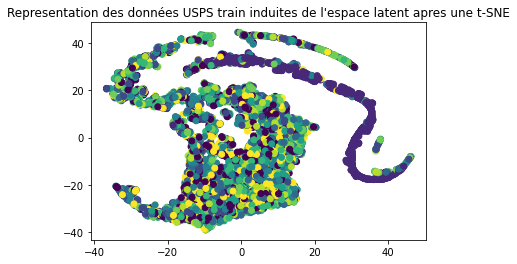

In [31]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)
repre_2D = tsne.fit_transform(X_train_hat)

plt.title("Representation des données USPS train induites de l'espace latent apres une t-SNE")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)

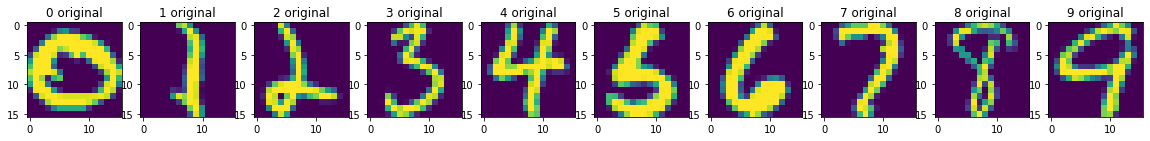

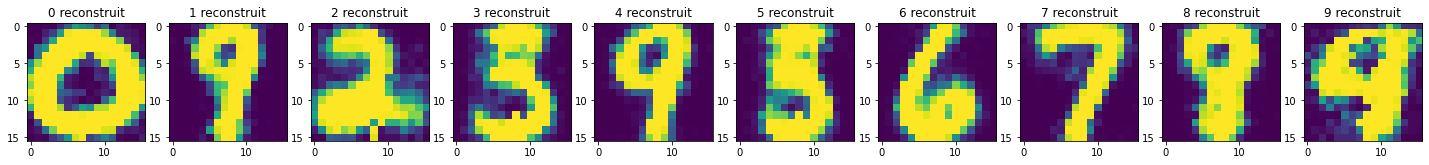

In [35]:
plt.figure(figsize=(20,15))
sample = np.random.randint(0,100)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_test[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_test_hat[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

#### variation du nombre d'epochs

Optimisation
Batch size :  100
Epochs :  100
Learning rate :  0.0001


100%|█████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


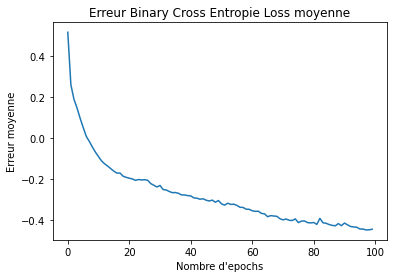

Optimisation
Batch size :  500
Epochs :  100
Learning rate :  0.0001


100%|█████████████████████████████████████████| 100/100 [03:30<00:00,  2.10s/it]


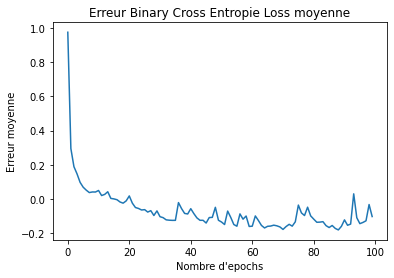

Optimisation
Batch size :  800
Epochs :  100
Learning rate :  0.0001


100%|█████████████████████████████████████████| 100/100 [02:24<00:00,  1.44s/it]


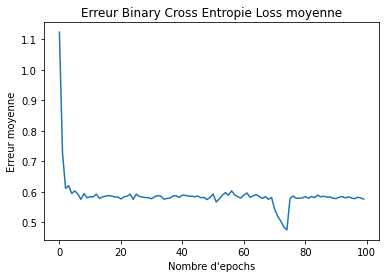

Optimisation
Batch size :  1000
Epochs :  100
Learning rate :  0.0001


100%|█████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


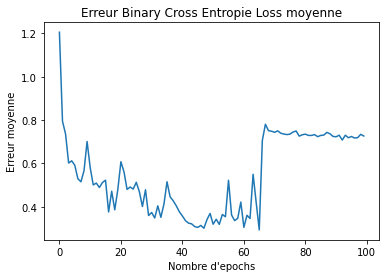

In [31]:
np.random.seed(42)
nb_classes = len(np.unique(Y_train))
n_samples = X_train.shape[0]

neuro_i_1 = 256
neuro_o_1 = 160
neuro_i_2 = 160
neuro_o_2 = 120
neuro_i_3 = 120
neuro_o_3 = 60
neuro_i_4 = 60
neuro_o_4 = 10
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 100
#batch_list = [20,50,100,150,200,300]
batch_list = [100,500,800,1000]
epochs = 100
nb_couches = 4


facteur_norma = 0.8


TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
BCE = BinaryCrossEntropie()
auto_encodeur_usps_list = []

for i,batch_size in enumerate(batch_list):

    lineaire_1_enc = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
    lineaire_2_enc = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
    lineaire_3_enc = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)
    lineaire_4_enc = ModuleLineaire(neuro_i_4 ,neuro_o_4 ,plage_biais,facteur_norma,init=1)

    lineaire_1_dec = ModuleLineaire(neuro_o_1 ,neuro_i_1 ,plage_biais,facteur_norma,init=1)
    lineaire_2_dec = ModuleLineaire(neuro_o_2 ,neuro_i_2 ,plage_biais,facteur_norma,init=1)
    lineaire_3_dec = ModuleLineaire(neuro_o_3 ,neuro_i_3 ,plage_biais,facteur_norma,init=1)
    lineaire_4_dec = ModuleLineaire(neuro_o_4 ,neuro_i_4 ,plage_biais,facteur_norma,init=1)


    network_layers = [lineaire_1_enc,TanH,lineaire_2_enc,TanH,lineaire_3_enc,TanH,lineaire_4_enc,TanH,
                      lineaire_4_dec,TanH,lineaire_3_dec,TanH,lineaire_2_dec,TanH,lineaire_1_dec,sigmoide]
    
    network = Sequentiel(network_layers)

    auto_encodeur_usps = AutoEncodeur(network,BCE)
    auto_encodeur_usps.optimisation(X_train,Y_train,batch_size,epochs,1e-4)
    auto_encodeur_usps_list.append(auto_encodeur_usps)

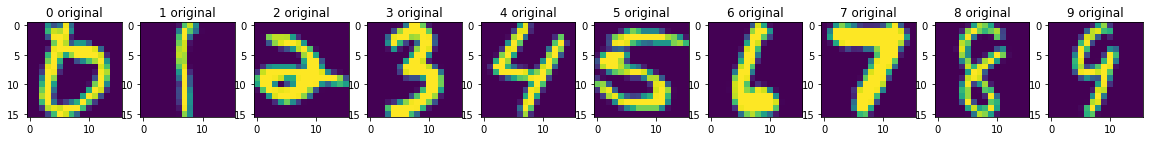

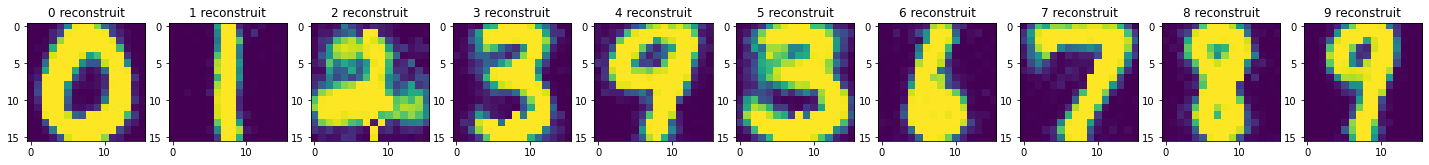

In [44]:
latent_repre = auto_encodeur_usps_list[0].encode(X_train)
X_train_hat = auto_encodeur_usps_list[0].decode(latent_repre)

plt.figure(figsize=(20,15))
sample = np.random.randint(0,100)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_train[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_train_hat[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

In [ ]:
pca_1 = PCA(n_components=2,random_state=96)
pca_1.fit(X_train_hat)

pca_2 = PCA(n_components=2,random_state=96)
pca_2.fit(X_train)

for i in tqdm(range(4)):
    latent_repre = auto_encodeur_usps_list[i].encode(X_train)
    X_train_hat = auto_encodeur_usps_list[i].decode(latent_repre)

    X_train_hat_pca = pca_1.transform(X_train_hat)
    X_train_pca = pca_2.transform(X_train)

    plt.figure(figsize=(15,7))

    plt.subplot(i+1,2,1)
    plt.scatter(X_train_hat_pca[:,0],X_train_hat_pca[:,1])
    plt.title("Nuage de points X_Train_Hat sur deux dimension")

    plt.subplot(i+1,2,2)
    plt.scatter(X_train_pca[:,0],X_train_pca[:,1])
    plt.title("Nuage de points X_Train sur deux dimension")


plt.show()

In [26]:
auto_encodeur_usps_list[1].opti.getNetwork().getModules()[4]._parameters

array([[-0.06363123, -0.4448769 ,  0.06539431, ...,  0.18543795,
         0.05451867,  0.09404492],
       [-0.58625863,  0.40201375,  0.06706136, ..., -0.46655041,
        -0.42238021, -0.10682748],
       [-0.42820158, -0.32986714,  0.6978401 , ..., -0.09484774,
         0.06387783, -0.12286032],
       ...,
       [-0.35358141,  0.28509465, -0.0209253 , ...,  0.76859021,
        -0.66561773, -0.17661733],
       [-0.18510824, -0.59077726, -0.20015868, ..., -0.28913205,
         0.11983878,  0.01361253],
       [-0.09695629,  0.45073419,  0.48612997, ..., -0.49037864,
         0.07499974,  0.80454015]])

In [60]:
latent_repre = auto_encodeur_usps.encode(X_train)
kmeans = KMeans(n_clusters=10, random_state=0, max_iter=100).fit(latent_repre)
yhat = kmeans.labels_

print("Pureté du clustering : ",cluster_purity(yhat,Y_train))
print("Rand score  : ",rand_score(yhat,Y_train))
print("Adjusted Rand Score : ",adjusted_rand_score(yhat,Y_train))

Pureté du clustering :  0.5435864504735912
Rand score  :  0.8783647931810034
Adjusted Rand Score :  0.35575037637929546


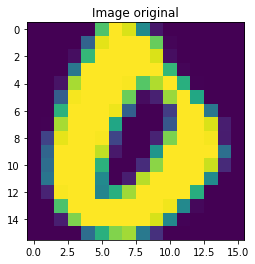

Similarité sur les images de test  :  0.884001303356142


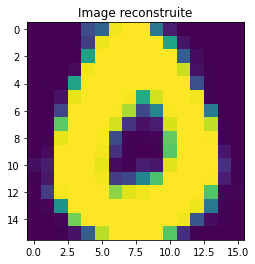

In [61]:
affiche_image(X_test,15,"Image original")
plt.show()
affiche_image(X_test_hat,15,"Image reconstruite")

# calculer l'accuracy de similarité entre l'image sortie du reseau et l'image de base
print("Similarité sur les images de test  : ",similarity(X_test_hat,X_test))

In [24]:
def cluster_purity(labels_true, labels_pred):

    labels_true = np.asarray(labels_true)
    labels_pred = np.asarray(labels_pred)
    assert labels_true.shape == labels_pred.shape  
    
    # Trouver les étiquettes les plus communes dans chaque cluster
    clusters = np.unique(labels_pred)
    n = len(labels_true)
    counts = np.zeros((len(clusters), len(np.unique(labels_true))))
    for i, c in enumerate(clusters):
        mask = labels_pred == c
        labels = labels_true[mask]
        counts[i, :] = np.bincount(labels, minlength=len(counts[i, :]))
    
    # Trouver la pureté en utilisant les étiquettes les plus communes
    purity = np.sum(np.max(counts, axis=1)) / n
    
    return purity

In [46]:
latent_repre = auto_encodeur_usps.encode(X_train)

kmeans = KMeans(n_clusters=10, random_state=0, max_iter=100).fit(latent_repre)
yhat = kmeans.labels_

print("Pureté du clustering : ",cluster_purity(yhat,Y_train))
print("Rand score  : ",rand_score(yhat,Y_train))
print("Adjusted Rand Score : ",adjusted_rand_score(yhat,Y_train))

Pureté du clustering :  0.6445657408893883
Rand score  :  0.8979527152143212
Adjusted Rand Score :  0.46372700582144394


In [44]:
yhat

array([6, 1, 3, ..., 0, 6, 8], dtype=int32)

## Represenation latente et clustering

### Credit Card without labels

In [2]:
cc_data = pd.read_csv("data/CC GENERAL.csv")

In [3]:
cc_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [4]:
# supprimer les valeurs NaN
cc_data = cc_data.dropna()

cc_data = np.array(cc_data)
# supprimer la colonne 1
cc_data = cc_data[:,1:]
cc_data = cc_data.astype('float')
y = np.random.randint(0,1,cc_data.shape[0])

data_norm = normalisation(cc_data)
data_norm = data_norm.astype('float')

Optimisation
Batch size :  200
Epochs :  200
Learning rate :  0.0001


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 34.62it/s]


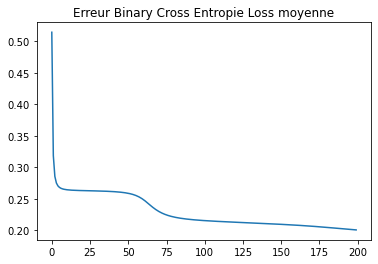

In [5]:
np.random.seed(42)
n_samples = data_norm.shape[0]

neuro_i_1 = 17
neuro_o_1 = 10
neuro_i_2 = 10
neuro_o_2 = 7

plage_biais = (0,1)
batch_size = 200
epochs = 200
nb_couches = 2


facteur_norma = 0.8
lineaire_1_enc = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
lineaire_2_enc = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)

lineaire_1_dec = ModuleLineaire(neuro_o_1 ,neuro_i_1 ,plage_biais,facteur_norma,init=1)
lineaire_2_dec = ModuleLineaire(neuro_o_2 ,neuro_i_2 ,plage_biais,facteur_norma,init=1)


TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
BCE = BinaryCrossEntropie()


network_layers = [lineaire_1_enc,sigmoide,lineaire_2_enc,TanH,
                  lineaire_2_dec,sigmoide,lineaire_1_dec,sigmoide]
network = Sequentiel(network_layers)

auto_encodeur_ccdata = AutoEncodeur(network,BCE)

auto_encodeur_ccdata.optimisation(data_norm,y,batch_size,epochs,1e-4)

latent_repre = auto_encodeur_ccdata.encode(data_norm)
data_norm_hat = auto_encodeur_ccdata.decode(latent_repre)

In [6]:
kmeans = KMeans(n_clusters=10, random_state=0, max_iter=100).fit(data_norm_hat)

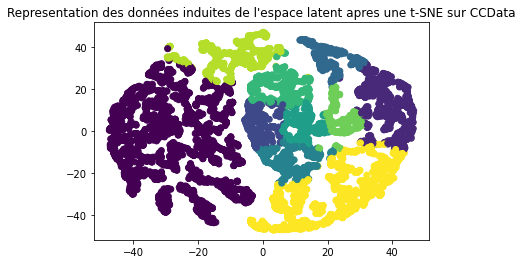

In [7]:
yhat = kmeans.labels_

tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)
repre_2D = tsne.fit_transform(data_norm_hat)

plt.title("Representation des données induites de l'espace latent apres une t-SNE sur CCData")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=yhat)

## Debruitage de données

In [ ]:
seed = 42
np.random.seed(seed)
pos_cen = (-12, -12)
pos_sig = [[1, 4], [4, 1]]

neg_cen = (-2, -2)
neg_sig = [[1, 5], [4, 1]]
data,labels = genere_dataset_gaussian(pos_cen,pos_sig,neg_cen,neg_sig,100,-1,1)
print("Données avant bruitage")
plot2D(data,labels)

shape = data.shape
mean = 2
std = 4
noise = genrate_noise(shape,law='normal',mean,std)

data_noised = data + noise
print("Données apres bruitage")
plot2D(data_noised,labels)

In [20]:
BCE.forward(X_train,X_train_hat).mean()

-0.29486325507713085